In [37]:
%matplotlib inline

In [38]:
from __future__ import division

import pandas as pd
from pandas.plotting import scatter_matrix
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

import pydotplus
from IPython.display import Image

import re
from textblob import TextBlob
from textblob.classifiers import NaiveBayesClassifier

In [39]:
plt.style.use('ggplot')

In [40]:
infile = 'ya.csv'

In [41]:
df_ya = pd.read_csv(infile)

In [42]:
df_ya.describe()

,Star rating,Number of reviews,Length
count,100.000000,100.00000,100.000000
mean,4.315000,164.55000,327.440000
std,0.399842,261.62601,116.095861
min,3.000000,1.00000,52.000000
25%,4.000000,28.00000,242.000000
50%,4.500000,74.50000,323.000000
75%,4.500000,179.00000,400.000000
max,5.000000,1591.00000,793.000000


### initial observations
    - 100 observations, 56 unique publishers, 96 unique authors
    - only 3 authors with more than 1 title, so will do analysis at title level
    - titles can be from a series, but the rest of the series not necessarily in the data
    - only 100 records, so can't go overboard with number of features
    - are there synonyms: "Chelsea M. Cameron vs. Chelsea M. Campbell", "E. K. Johnston vs. E. Katherine Kottaras"

### candidate features
    1. is the title part of a series?
    2. acronym in author name?
    3. sentiment of title (after removing explanatory part of title)
    4. length of the title

In [43]:
def series(a_string):
    p = re.compile(r'(?:Book|Vol.?)\s(?:One|Two|Three|Four|Five|Six|Seven|Eight|Nine|Ten|\d+)\b', re.I)
    nums = p.findall(a_string)
    if len(nums)==0:
        return 'standalone'
    elif len(re.findall(r'One|1', nums[0], re.I))>0:
        return 'first'
    else:
        return 'sequel'

In [44]:
def seriesv2(a_string):
    p = re.compile(r'(?:Book|Vol.?)\s(?:One|Two|Three|Four|Five|Six|Seven|Eight|Nine|Ten|\d+)\b', re.I)
    nums = p.findall(a_string)
    if len(nums)==0:
        return 'standalone'
    else:
        return 'series'

In [45]:
def acronym(a_string):
    p = re.compile(r'^[A-Z]\.')
    if len(p.findall(a_string)) > 0:
        return 1
    else:
        return 0

In [46]:
def trim_title(a_string):
    try:
        isx = re.search(r"\(", a_string).start()
        new_string = a_string[:isx]
    except:
        new_string =  a_string
    try:
        isx = re.search(r":", new_string).start()
        new_string2 = new_string[:isx]
    except:
        new_string2 =  new_string   
    return new_string2

In [47]:
df_ya['success'] = df_ya.apply(lambda x: int((x['Star rating']>=4.5) & (x['Number of reviews']>=100)), axis=1)
df_ya['series'] = df_ya['Book title'].apply(seriesv2)
df_ya['acronym'] = df_ya['Author name'].apply(acronym)
df_ya['title_trimmed'] = df_ya['Book title'].apply(trim_title)
df_ya['sent'] = df_ya['title_trimmed'].apply(lambda x: TextBlob(x).sentiment.polarity)
df_ya['core_title_length'] = df_ya['title_trimmed'].apply(lambda x: len(x))
df_ya['amazon'] = df_ya['Publisher'].apply(lambda x: int(x.strip() == 'Amazon'))

In [48]:
df_ya['success'].mean()

0.27

In [49]:
df_ya.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 13 columns):
Book title           100 non-null object
Author name          100 non-null object
Star rating          100 non-null float64
Number of reviews    100 non-null int64
Length               100 non-null int64
Publisher            100 non-null object
success              100 non-null int64
series               100 non-null object
acronym              100 non-null int64
title_trimmed        100 non-null object
sent                 100 non-null float64
core_title_length    100 non-null int64
amazon               100 non-null int64
dtypes: float64(2), int64(6), object(5)
memory usage: 10.2+ KB


In [50]:
df_ya['series'].value_counts()

standalone    83
series        17
Name: series, dtype: int64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f16f053b1d0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f16ebacd650>]], dtype=object)

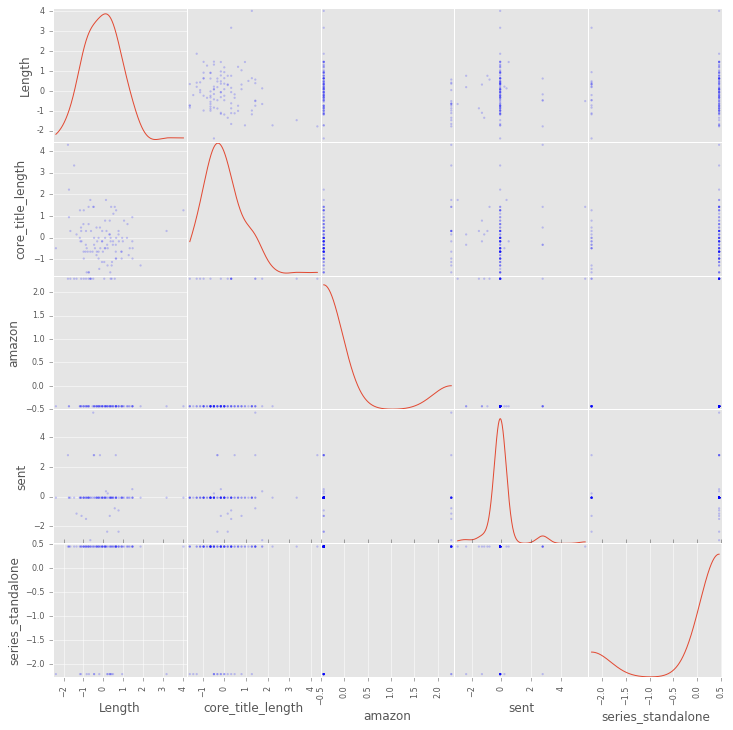

In [51]:
depVar = ['success']
indepVars = ['Length','core_title_length','series','amazon','sent']

df_yX = df_ya[depVar+indepVars]

y = df_yX[depVar[0]]
X = df_yX.drop(depVar[0], 1)

X = pd.get_dummies(X, drop_first=True)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X = pd.DataFrame(X_scaled, columns=X.columns)

scatter_matrix(X, alpha=0.2, figsize=(12, 12), diagonal='kde')

In [75]:
X['intercept'] = 1.0

X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.3)

('model score: ', 0.6333333333333333)


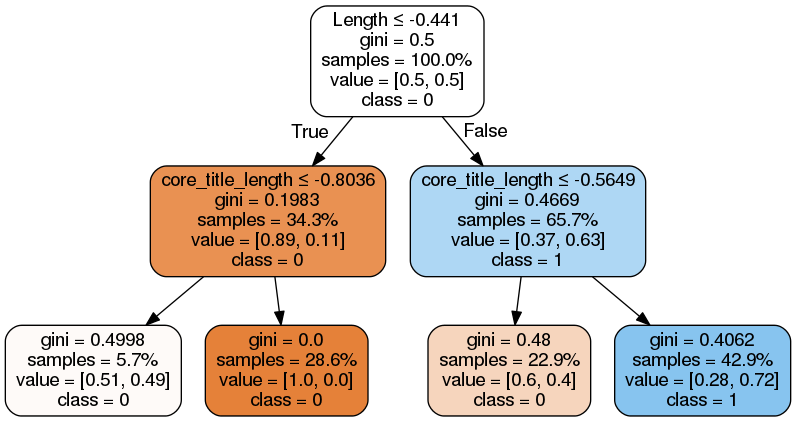

In [97]:
dtclf = tree.DecisionTreeClassifier(max_depth=2, class_weight='balanced').fit(X_train,y_train)
print("model score: ", dtclf.score(X_test,y_test))

dot_data = tree.export_graphviz(dtclf,
                                out_file=None,
                                feature_names=X_train.columns,
                                class_names=['0','1'],
                                filled=True,
                                rounded=True,
                                proportion=True,
                                special_characters=True)  
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

('model score: ', 0.6333333333333333)


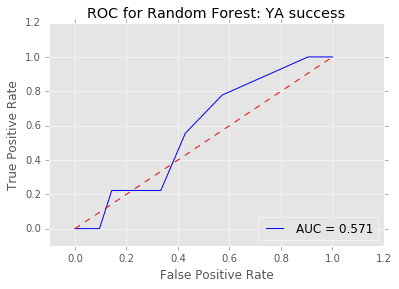

In [100]:
rfclf = RandomForestClassifier(class_weight='balanced')
rfclf = rfclf.fit(X_train,y_train)
print("model score: ", rfclf.score(X_test,y_test))

probs = rfclf.predict_proba(X_test)

fpr,tpr,th = roc_curve(y_test.values,probs[:,1])
roc_auc = auc(fpr,tpr)

plt.title('ROC for Random Forest: YA success')
plt.plot(fpr,tpr,'b',label='AUC = %0.3f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [85]:
vif = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

In [86]:
vif

[1.1169206444676292,
 1.099854414685135,
 1.1347602476325542,
 1.0328048152362541,
 1.0148531844940112,
 1.0]

In [102]:
logit = sm.Logit(y.astype('int'), X.astype('int'))
# fit the model
result = logit.fit()

print(result.summary())

Optimization terminated successfully.
         Current function value: 0.563435
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                success   No. Observations:                  100
Model:                          Logit   Df Residuals:                       94
Method:                           MLE   Df Model:                            5
Date:                Tue, 04 Jul 2017   Pseudo R-squ.:                 0.03399
Time:                        10:59:01   Log-Likelihood:                -56.343
converged:                       True   LL-Null:                       -58.326
                                        LLR p-value:                    0.5545
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Length                0.1566      0.306      0.511      0.609      -0.444       0.757
core_tit

In [103]:
pipeline = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', SGDClassifier()),
])

In [112]:
depVar = ['success']
indepVars = ['Book title']

df_yX = df_ya[depVar+indepVars]

y = df_yX[depVar[0]].values
X = df_yX.drop(depVar[0], 1)[indepVars].values.reshape(-1)

# X = [x[0] for x in X.tolist()]

X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.3)

In [113]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('vect', CountVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        st...   penalty='l2', power_t=0.5, random_state=None, shuffle=True,
       verbose=0, warm_start=False))])

In [114]:
predicted = pipeline.predict(X_test)

In [115]:
A = np.array([y_test,predicted])

In [116]:
np.sum(A[0]==A[1]) / len(A[0])

0.66666666666666663

In [117]:
train = zip(X_train,y_train)
test = zip(X_test, y_test)

In [118]:
cl = NaiveBayesClassifier(train)

In [119]:
cl.show_informative_features(5)

Most Informative Features
             contains(2) = True                1 : 0      =      6.1 : 1.0
         contains(Plain) = True                1 : 0      =      2.6 : 1.0
         contains(Glass) = True                1 : 0      =      2.6 : 1.0
         contains(Three) = True                1 : 0      =      2.6 : 1.0
          contains(Boys) = True                1 : 0      =      2.6 : 1.0


In [120]:
cl.accuracy(test)

0.76666666666666672